In [1]:
import chess
import chess.pgn
import numpy as np
import pandas as pd
import requests
import os
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from captum.attr import IntegratedGradients
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [3]:
os.chdir('..')

In [4]:
from chess_class import ChessGame, ChessMove

In [5]:
## Which PGN File To Train
max_games = 500000 #100000
asset_dir = 'asset'
file_name = '2023_10000_games.pgn'
file_name = '2023_tc_50000_games.pgn'

In [6]:
def save_item_to_file(games, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(games, file)

def load_item_from_file(file_path):
    if os.path.exists(file_path):
        print('loading item from cache...')
        with open(file_path, 'rb') as file:
            items = pickle.load(file)
        print('loaded')
        return items
    else:
        return None

def load_pgns(file_path, num_games=None, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

In [7]:
pgns = None
assets_path = os.path.join(os.getcwd(), asset_dir)
single_path = os.path.join(assets_path, file_name)

cached_pgns_file = file_name.split('.')[0] + '_pgn.pkl'
cached_urls_file = file_name.split('.')[0] + '_urls_list.pkl'
cached_ratings_file = file_name.split('.')[0] + '_ratings_list.pkl'
cached_games_file = file_name.split('.')[0] + '_game_arrays.pkl'
cached_pgns_path = os.path.join(assets_path, cached_pgns_file)
cached_urls_path = os.path.join(assets_path, cached_urls_file)
cached_ratings_path = os.path.join(assets_path, cached_ratings_file)
cached_games_path = os.path.join(assets_path, cached_games_file)

chess_games_loaded = True
urls_list = load_item_from_file(cached_urls_path)
ratings_list = load_item_from_file(cached_ratings_path)
game_arrays = load_item_from_file(cached_games_path)

if ratings_list is None:
    print('Creating new ratings_list and urls_list...')
if game_arrays is None:
    print('Creating new game_arrays...')
    chess_games_loaded = False

loading item from cache...
loaded
loading item from cache...
loaded
loading item from cache...


loaded


In [8]:
def chess_games_to_arrays(games_generator):
    def rating_to_group(rating):
        rating = int(rating)
        if rating < 800:
            return 0
        elif rating >= 2400:
            return 9
        return int(rating)//200 - 3

    attributes = ["ply_count", "time_category", "classification_name", "count_legal_moves", "force_moves_percent",
                  "game_state", "distance", "is_endgame", "has_increment", "in_time_trouble", "can_dirty_flag",
                  "is_check", "is_double_check", "is_discovered_check", "is_capture", "is_threat", "is_developing",
                  "is_retreating", "was_hanging", "is_hanging", "was_true_hanging", "is_true_hanging", "is_create_tension",
                  "is_resolve_tension", "is_maintain_tension", "start_square", "end_square", "threats", 
                  "create_tension", "maintain_tension", "resolve_tension", "piece_value"]
    
    game_arrays = []
    ratings_list = []
    urls_list = []
    for i, game in enumerate(tqdm(games_generator, total=max_games, desc="Processing games")):
        elo_w, elo_b, url = game.white_elo, game.black_elo, game.url
        total_plies = game.total_ply
        df = pd.DataFrame(columns=attributes)
        for j, move in enumerate(game.moves):
            move_row = {attribute: getattr(move, attribute, None) for attribute in attributes}
            df.loc[j] = move_row
        df['ply_count'] = df['ply_count'] / total_plies
        df['count_legal_moves'] = df['count_legal_moves'] / 128
        df['distance'] = (df['distance'] - 1) / 6

        df['prev_end_square'] = df['end_square'].shift(1).fillna(64)
        df['prev_threats'] = df['threats'].shift(1).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['prev_create_tension'] = df['create_tension'].shift(1).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['last_move_end_square'] = df['end_square'].shift(2).fillna(64)
        df['last_move_create_tension'] = df['create_tension'].shift(2).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['last_move_threats'] = df['threats'].shift(2).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
    
        df['is_reacting'] = df.apply(lambda row: row['prev_end_square'] in (row['create_tension'] | row['threats']), axis=1) | \
                            (df['prev_end_square'] == df['end_square']) | \
                            df.apply(lambda row: row['start_square'] in row['prev_threats'], axis=1)
        df['is_same_piece'] = df['last_move_end_square'] == df['start_square']
        df['veni_vidi_vici'] = df.apply(lambda row: row['end_square'] in (row['last_move_create_tension'] | row['last_move_threats']), axis=1)
        df['is_collinear'] = df.apply(lambda row: row['start_square'] in (row['prev_create_tension'] | row['prev_threats']), axis=1) | \
                            df.apply(lambda row: row['prev_end_square'] in row['create_tension'], axis=1)
        df.drop(columns=['prev_end_square', 'last_move_end_square', 'prev_threats', 'last_move_create_tension', 'prev_create_tension',
                         'last_move_threats', 'threats', 'create_tension', 'maintain_tension', 'resolve_tension'], inplace=True)

        df['moved_piece_king'] = df['piece_value'].apply(lambda x: 1 if x == 6 else 0)
        df['moved_piece_queen'] = df['piece_value'].apply(lambda x: 1 if x == 5 else 0)
        df['moved_piece_rook'] = df['piece_value'].apply(lambda x: 1 if x == 4 else 0)
        df['moved_piece_bishop'] = df['piece_value'].apply(lambda x: 1 if x == 3 else 0)
        df['moved_piece_knight'] = df['piece_value'].apply(lambda x: 1 if x == 2 else 0)
        df['moved_piece_pawn'] = df['piece_value'].apply(lambda x: 1 if x == 1 else 0)
        df['time_category_instant'] = df['time_category'].apply(lambda x: 1 if x == 'instant' else 0)
        df['time_category_fast'] = df['time_category'].apply(lambda x: 1 if x == 'fast' else 0)
        df['time_category_normal'] = df['time_category'].apply(lambda x: 1 if x == 'normal' else 0)
        df['time_category_slow'] = df['time_category'].apply(lambda x: 1 if x == 'slow' else 0)
        df['classification_name_Great'] = df['classification_name'].apply(lambda x: 1 if x == 'Great' else 0)
        df['classification_name_Good'] = df['classification_name'].apply(lambda x: 1 if x == 'Good' else 0)
        df['classification_name_Inaccuracy'] = df['classification_name'].apply(lambda x: 1 if x == 'Inaccuracy' else 0)
        df['classification_name_Blunder'] = df['classification_name'].apply(lambda x: 1 if x == 'Blunder' else 0)
        df['classification_name_Mistake'] = df['classification_name'].apply(lambda x: 1 if x == 'Mistake' else 0)

        df = df.drop(['classification_name', 'time_category', 'piece_value', 'start_square', 'end_square'], axis=1)

        game_array_rep = df.astype(float).to_numpy()
        game_arrays.append(game_array_rep)
        ratings_list.append(rating_to_group((elo_w + elo_b)/2))
        #ratings_list.append([elo_w, elo_b])
        urls_list.append(url)
    return game_arrays, ratings_list, urls_list

In [9]:
if not chess_games_loaded:
    pgns = load_item_from_file(cached_pgns_path)
    if pgns is None:
        pgns = load_pgns(single_path, max_games)
        save_item_to_file(pgns, cached_pgns_path)
    #games_generator = (ChessGame(pgn) for pgn in pgns)
    games_generator = (ChessGame(pgn) for i, pgn in enumerate(pgns) if i % 5 == 0)
    game_arrays, ratings_list, urls_list  = chess_games_to_arrays(games_generator)
    save_item_to_file(game_arrays, cached_games_path)
    save_item_to_file(ratings_list, cached_ratings_path)
    save_item_to_file(urls_list, cached_urls_path)

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.dropout(F.relu(self.fc4(out)))
        out = self.dropout(F.relu(self.fc5(out)))
        out = self.dropout(F.relu(self.fc6(out)))
        out = self.dropout(F.relu(self.fc7(out)))
        classification_output = self.fc_classification(out)
        regression_output = self.fc_regression(out)
        return classification_output, regression_output

In [11]:
def combined_loss(classification_output, regression_output, target, alpha=0.5):
    classification_loss = nn.CrossEntropyLoss()(classification_output, target)
    regression_target = target.float()
    regression_loss = nn.MSELoss()(regression_output.squeeze(), regression_target)
    return alpha * classification_loss + (1 - alpha) * regression_loss

def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha=0.5):
    torets = []
    for epoch in range(num_epochs):
        model.train()
        for i, (moves, labels) in enumerate(train_loader):  
            moves = moves.to(device)
            labels = labels.to(device)

            classification_output, regression_output = model(moves)
            loss = combined_loss(classification_output, regression_output, labels, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        toret = [x/20000 for x in pred_closeness]
        torets.append(toret)
    return torets

def test_model(model, test_loader, device):
    model.eval()
    n_correct = 0
    n_samples = 0
    predicted_probs = []
    predicted_labels = []
    actual_labels = []
    with torch.no_grad():
        for moves, labels in test_loader:
            moves = moves.to(device)
            labels = labels.to(device)
            classification_output, _ = model(moves)
            probabilities = F.softmax(classification_output, dim=1)

            _, predicted = torch.max(classification_output.data, 1)
            predicted_probs.extend(probabilities.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test moves: {acc} %')
    return predicted_probs, predicted_labels, actual_labels

In [12]:
input_size = 42
num_classes = 10
num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001

torch.manual_seed(64)

In [13]:
def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

padded_games = [pad_game(g, sequence_length) for g in game_arrays]

PIECE: [0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 27, 28, 29, 30, 31, 32]
TIME: [6, 7, 8, 33, 34, 35, 36]
ENGINE: [3, 37, 38, 39, 40, 41]
DOMAIN: [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

['ply_count', 'count_legal_moves', 'force_moves_percent', 'game_state',
       'distance', 'is_endgame', 'has_increment', 'in_time_trouble',
       'can_dirty_flag', 'is_check', 'is_double_check', 'is_discovered_check',
       'is_capture', 'is_threat', 'is_developing', 'is_retreating',
       'was_hanging', 'is_hanging', 'was_true_hanging', 'is_true_hanging',
       'is_create_tension', 'is_resolve_tension', 'is_maintain_tension',
       'is_reacting', 'is_same_piece', 'veni_vidi_vici', 'is_collinear',
       'moved_piece_king', 'moved_piece_queen', 'moved_piece_rook',
       'moved_piece_bishop', 'moved_piece_knight', 'moved_piece_pawn',
       'time_category_instant', 'time_category_fast', 'time_category_normal',
       'time_category_slow', 'classification_name_Great',
       'classification_name_Good', 'classification_name_Inaccuracy',
       'classification_name_Blunder', 'classification_name_Mistake']


#### PIECE

'moved_piece_king'
'moved_piece_queen'
'moved_piece_rook'
'moved_piece_bishop'
'moved_piece_knight'
'moved_piece_pawn'
'distance'
'is_check'
'is_double_check'
'is_discovered_check'
'is_capture'
'is_developing'
'is_retreating'
'ply_count'
'is_endgame'
'count_legal_moves'
'force_moves_percent'

#### TIME

'time_category_instant'
'time_category_fast'
'time_category_normal'
'time_category_slow'
'has_increment'
'in_time_trouble'
'can_dirty_flag'
    
#### ENGINE

'classification_name_Great'
'classification_name_Good'
'classification_name_Inaccuracy'
'classification_name_Blunder'
'classification_name_Mistake'
'game_state'

#### DOMAIN

'was_hanging'
'is_hanging'
'was_true_hanging'
'is_true_hanging'
'is_create_tension'
'is_resolve_tension'
'is_maintain_tension'
'is_threat'
'is_reacting'
'is_same_piece'
'veni_vidi_vici'
'is_collinear'

In [14]:
def get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    test_list = padded_games[fold_number::5]
    train_list = [df for i in range(5) if i != fold_number for df in padded_games[i::5]]
    test_ratings = ratings_list[fold_number::5]
    train_ratings = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    train_data = [torch.FloatTensor(doc) for doc in train_list]
    test_data = [torch.FloatTensor(doc) for doc in test_list]
    train_labels = torch.LongTensor(train_ratings)
    test_labels = torch.LongTensor(test_ratings)

    train_dataset = TensorDataset(torch.stack(train_data), train_labels)
    test_dataset = TensorDataset(torch.stack(test_data), test_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_urls, test_urls

In [15]:
train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, ratings_list, urls_list, batch_size)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
model_path = file_name.split('.')[0] + '_pred.pth'
model_path = '2023_tc_50000_games_pred.pth'
model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')
#model.load_state_dict(torch.load(model_path, map_location=device))
#model.to(device)

The model has 291,011 trainable parameters


In [18]:
%%time
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    #model.load_state_dict(torch.load('2023_tc_500000_games_pred.pth', map_location=device))
    model.to(device)
except:
    print('path not found')
    lists = train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha)
predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)

Accuracy of the network on the test moves: 33.02 %
CPU times: total: 547 ms
Wall time: 1.6 s


In [19]:
torch.save(model.state_dict(), model_path)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
#model.load_state_dict(torch.load(model_path, map_location=device))
#model.to(device)
model

RNN(
  (lstm): LSTM(42, 100, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=100, bias=True)
  (fc7): Linear(in_features=100, out_features=100, bias=True)
  (fc_classification): Linear(in_features=100, out_features=10, bias=True)
  (fc_regression): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [20]:
test_list = padded_games[::5]
test_data = [torch.FloatTensor(doc) for doc in test_list][::200]
X_test_tensor = torch.stack(test_data).to(device)

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        classification_output, regression_output = self.model(x)
        return regression_output
        #return classification_output

model_wrapper = ModelWrapper(model).to(device)
model_wrapper.train()
integrated_gradients = IntegratedGradients(model_wrapper)
#baselines = torch.zeros(X_test_tensor.shape, dtype=torch.float32).to(device)
baselines = torch.full(X_test_tensor.shape, -1, dtype=torch.float32).to(device)
attributions = integrated_gradients.attribute(X_test_tensor, baselines=baselines)
#attributions = integrated_gradients.attribute(X_test_tensor, baselines=baselines, target=0)

In [21]:
strength = attributions.mean(dim=0).mean(dim=0).cpu().numpy()
feats = ['ply_count', 'count_legal_moves', 'force_moves_percent', 'game_state',
        'distance', 'is_endgame', 'has_increment', 'in_time_trouble',
        'can_dirty_flag', 'is_check', 'is_double_check', 'is_discovered_check',
        'is_capture', 'is_threat', 'is_developing', 'is_retreating',
        'was_hanging', 'is_hanging', 'was_true_hanging', 'is_true_hanging',
        'is_create_tension', 'is_resolve_tension', 'is_maintain_tension',
        'is_reacting', 'is_same_piece', 'veni_vidi_vici', 'is_collinear',
        'moved_piece_king', 'moved_piece_queen', 'moved_piece_rook',
        'moved_piece_bishop', 'moved_piece_knight', 'moved_piece_pawn',
        'time_category_instant', 'time_category_fast', 'time_category_normal',
        'time_category_slow', 'classification_name_Great',
        'classification_name_Good', 'classification_name_Inaccuracy',
        'classification_name_Blunder', 'classification_name_Mistake']

feats_df = pd.DataFrame({'feature':feats, 'strength':strength})
sorted_feats_df = feats_df.sort_values(by='strength', ascending=False)
sorted_feats_df.reset_index(drop=True)

,feature,strength
0,count_legal_moves,0.019107
1,distance,0.016930
2,classification_name_Great,0.013046
3,is_create_tension,0.010896
4,is_threat,0.009253
5,time_category_slow,0.008744
6,time_category_instant,0.008105
7,is_hanging,0.007717
8,is_resolve_tension,0.006327
9,is_developing,0.005518


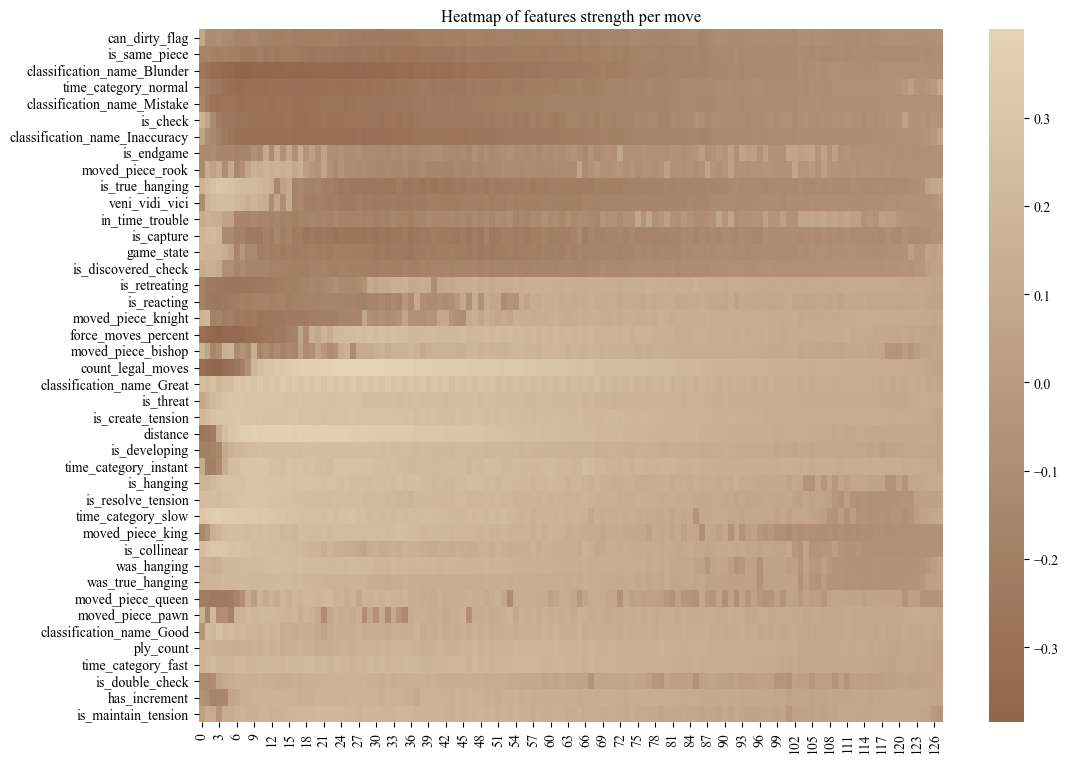

In [22]:
raw_game_features_df = pd.DataFrame((attributions.mean(dim=0).cpu().numpy()), columns=feats)
game_features_df = np.cbrt(raw_game_features_df)

Z = linkage(game_features_df.T, 'ward')
col_order = leaves_list(Z)
clustered_df = game_features_df.iloc[:, col_order]

darkest_hex = "#90664b"
lightest_hex = "#e5d3b3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", [darkest_hex, lightest_hex])

plt.figure(figsize=(12, 9))
ax = sns.heatmap(clustered_df.T, annot=False, cmap=custom_cmap, fmt=".4f")
ax.set_title('Heatmap of features strength per move')
plt.show()

In [23]:
pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
pred_closeness

[6604, 14963, 18332, 19536, 19874, 19973, 19997, 19999, 20000, 20000]

In [24]:
truths_counter = Counter(actual_labels)
preds_counter = Counter(predicted_labels)
actual_df = pd.DataFrame(list(truths_counter.items()), columns=['Label', 'Actual Count'])
predicted_df = pd.DataFrame(list(preds_counter.items()), columns=['Label', 'Predicted Count'])
merged_df = pd.merge(actual_df, predicted_df, on='Label', how='outer').fillna(0)
sorted_df = merged_df.set_index('Label').sort_index()
sorted_df.T

Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1625,2149,2091,2043,2026,2116,2157,2114,2059,1620
Predicted Count,1975,2384,1630,1419,2364,1801,2084,2171,2971,1201


In [25]:
corrects_list = []
recall_list = []
for i in range(10):
    indices = [index for index, value in enumerate(actual_labels) if value == i]
    totals = [predicted_labels[ind] for ind in indices]
    corrects = [value for value in totals if value == i]
    rate = len(corrects)/len(totals)
    corrects_list.append(len(corrects))
    recall_list.append(rate)

sorted_df['Correct Predictions'] = corrects_list
sorted_df['Identify Rate'] = pd.Series(recall_list).round(3)
sorted_df.T

Label,0,1,2,3,4,5,6,7,8,9
Actual Count,1625.000,2149.000,2091.000,2043.000,2026.000,2116.000,2157.000,2114.000,2059.000,1620.000
Predicted Count,1975.000,2384.000,1630.000,1419.000,2364.000,1801.000,2084.000,2171.000,2971.000,1201.000
Correct Predictions,1018.000,858.000,497.000,381.000,599.000,468.000,550.000,572.000,1000.000,661.000
Identify Rate,0.626,0.399,0.238,0.186,0.296,0.221,0.255,0.271,0.486,0.408


In [26]:
print("Some Predictions:")
hard_truths = []
overconfidents = []
awfuls = []
perfects = []
for i, (t,g) in enumerate(zip(actual_labels, predicted_labels)):
    truth = predicted_probs[i][t]
    guess = predicted_probs[i][g]
    if truth < 0.05:
        hard_truths.append(i)
    if guess > 0.3 and t != g:
        overconfidents.append(i)
    if abs(t-g) > 5:
        awfuls.append(i)
    if abs(t-g) == 0:
        perfects.append(i)

len(hard_truths) / len(actual_labels), len(overconfidents) / len(actual_labels), len(awfuls) / len(actual_labels)

Some Predictions:


(0.0724, 0.34535, 0.00135)

In [27]:
perfect_pred_urls = [test_urls[i] for i in perfects]
len(perfect_pred_urls)

6604

In [47]:
indexperf = 3579
print(actual_labels[perfects[indexperf]])
perfect_pred_urls[indexperf]

5


'https://lichess.org/nOPc1SZj'

In [28]:
bad_pred_urls = [test_urls[i] for i in awfuls]
predictions = [(predicted_labels[i], actual_labels[i]) for i in awfuls]

folder_path = f'{asset_dir}/bad_preds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

def download_and_save_file(game_id, ind, predictions=predictions):
    export_url = f'https://lichess.org/game/export/{game_id}?literate=1'
    response = requests.get(export_url)
    if response.status_code == 200:
        file_path = os.path.join(folder_path, f'{game_id}.pgn')
        with open(file_path, 'wb') as file:
            file.write(response.content)
        return predictions[ind]
    else:
        return None

download_results = {}
for ind, url in enumerate(bad_pred_urls):
    if url.startswith('https://lichess.org/'):  # Check if the URL seems valid
        game_id = url.split('/')[-1]
        download_results[url] = download_and_save_file(game_id, ind)
download_results

{'https://lichess.org/w2yypnVF': (6, 0),
 'https://lichess.org/oucgmz9H': (7, 1),
 'https://lichess.org/TWPCOcmY': (6, 0),
 'https://lichess.org/BPzTCPxw': (7, 1),
 'https://lichess.org/W9GB6Irk': (7, 1),
 'https://lichess.org/oQ2zfqUT': (7, 1),
 'https://lichess.org/pd6TU1U0': (8, 1),
 'https://lichess.org/CL7kj0OG': (7, 1),
 'https://lichess.org/yMdFaNz9': (6, 0),
 'https://lichess.org/6Mnv9cND': (7, 1),
 'https://lichess.org/ZJ6Zm1p7': (7, 1),
 'https://lichess.org/5czAptup': (8, 2),
 'https://lichess.org/bn7Oes7W': (8, 2),
 'https://lichess.org/XQEjPXuL': (9, 3),
 'https://lichess.org/lrWFK1Iy': (0, 6),
 'https://lichess.org/62WBWXWU': (0, 6),
 'https://lichess.org/aG1PRwuV': (0, 7),
 'https://lichess.org/KehXcTrK': (1, 7),
 'https://lichess.org/gGgFuB4n': (1, 7),
 'https://lichess.org/nwNVI4SO': (1, 7),
 'https://lichess.org/9agXlVUB': (1, 7),
 'https://lichess.org/TrSWC4Pm': (1, 7),
 'https://lichess.org/gMNO4mqW': (1, 7),
 'https://lichess.org/nGoZtBhl': (2, 8),
 'https://liches

In [29]:
[x/20000 for x in pred_closeness]
#DecisionTree: 0.13315
#[0.13315, 0.36935, 0.5338, 0.6644, 0.77155, 0.85795, 0.9267, 0.97365, 0.9982, 1.0] 

#Linear Regression: 0.1153
#[0.1153, 0.33595, 0.5593, 0.77675, 0.94015, 0.99575, 0.9997, 0.99995, 1.0, 1.0]

#len of game as var

[0.3302, 0.74815, 0.9166, 0.9768, 0.9937, 0.99865, 0.99985, 0.99995, 1.0, 1.0]

In [30]:
predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)

Accuracy of the network on the test moves: 33.02 %


In [31]:
label_count_mat = np.zeros((10, 10))
np.add.at(label_count_mat, (np.array(actual_labels), np.array(predicted_labels)), 1)

label_prob_mat = []
for label in range(10):
    mask = np.array(actual_labels) == label
    probs = np.array([p for p,masking in zip(predicted_probs,mask) if masking]).mean(axis=0)
    label_prob_mat.append(probs)
label_prob_mat = np.array(label_prob_mat)

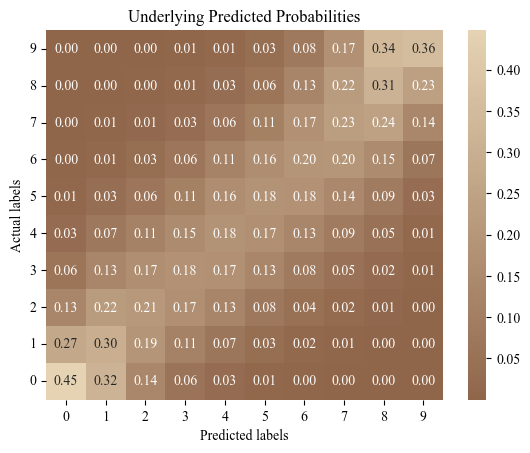

In [32]:
ax = sns.heatmap(label_prob_mat[::-1], annot=True, cmap=custom_cmap, fmt=".2f")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Underlying Predicted Probabilities")

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center', fontsize="10")
ax.set_yticklabels(range(9, -1, -1), rotation=0, verticalalignment='center')

plt.show()

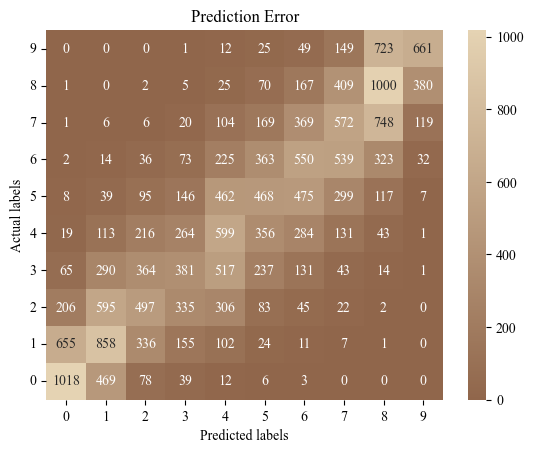

In [33]:
ax = sns.heatmap(label_count_mat[::-1], annot=True, cmap=custom_cmap, fmt=".0f")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Prediction Error")

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center', fontsize="10")
ax.set_yticklabels(range(9, -1, -1), rotation=0, verticalalignment='center')

plt.show()

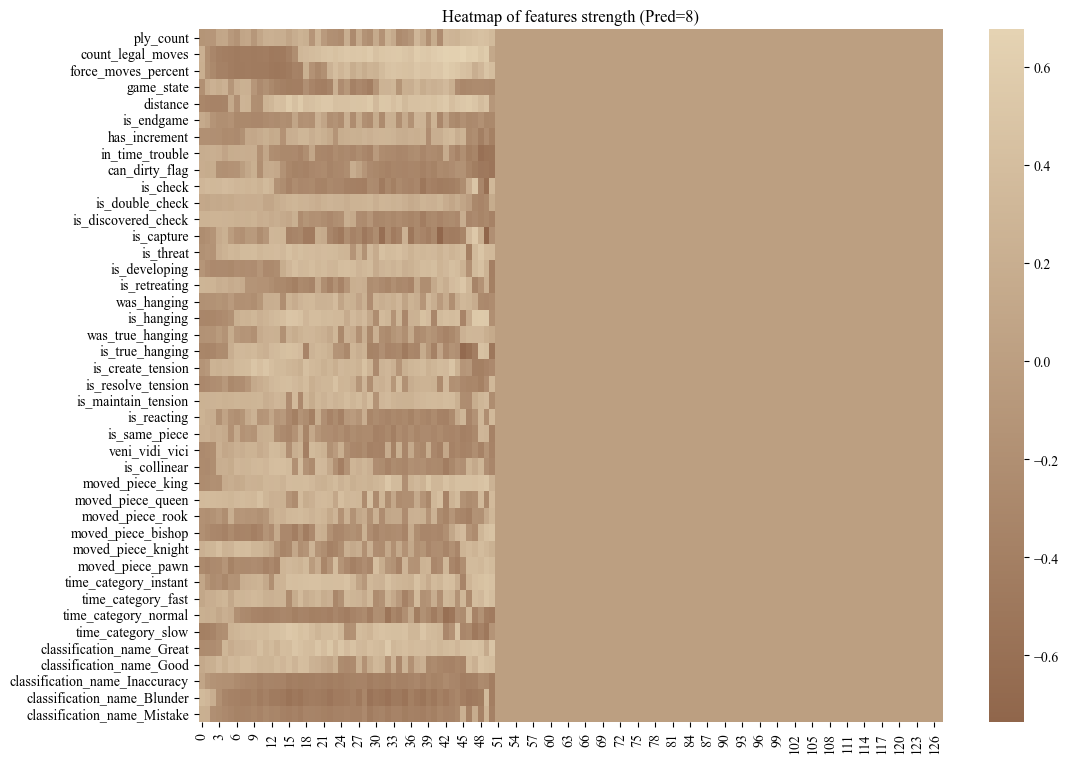

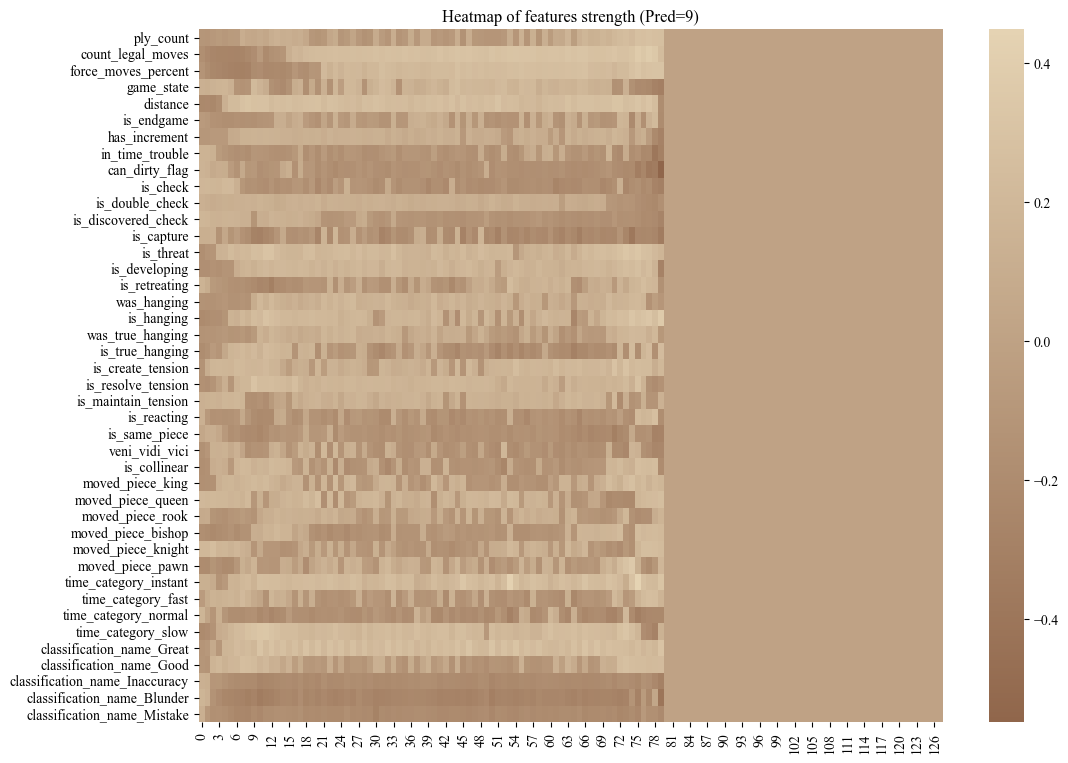

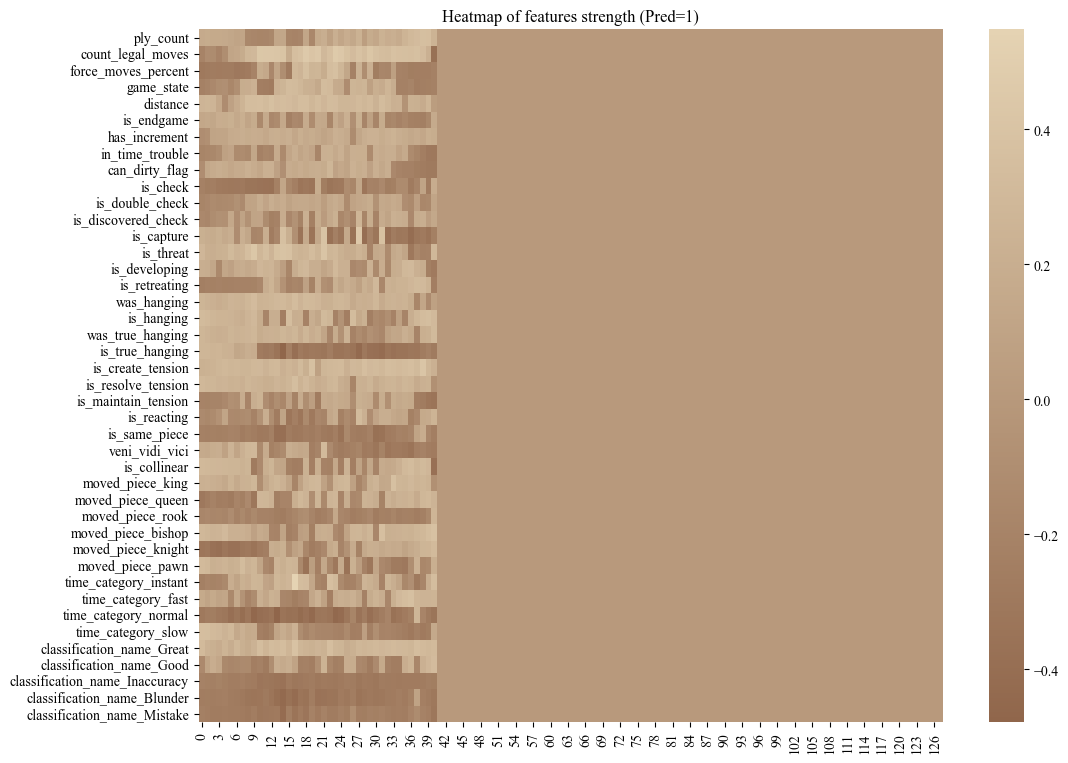

In [49]:
test_list = padded_games[::5]
for n,p in zip([11,13,-7],[8,9,1]):
    test_data = [torch.FloatTensor(doc) for doc in test_list][awfuls[n]::20000]
    #test_data = [torch.FloatTensor(doc) for doc in test_list][awfuls[13]]
    #test_data = [torch.FloatTensor(doc) for doc in test_list][awfuls[-7]]
    X_test_tensor = torch.stack(test_data).to(device)

    model_wrapper = ModelWrapper(model).to(device)
    model_wrapper.train()
    integrated_gradients = IntegratedGradients(model_wrapper)
    baselines = torch.full(X_test_tensor.shape, -1, dtype=torch.float32).to(device)
    attributions = integrated_gradients.attribute(X_test_tensor, baselines=baselines)

    raw_game_features_df = pd.DataFrame((attributions.mean(dim=0).cpu().numpy()), columns=feats)
    game_features_df = np.cbrt(raw_game_features_df)

    Z = linkage(game_features_df.T, 'ward')
    col_order = leaves_list(Z)
    clustered_df = game_features_df.iloc[:, col_order]

    plt.figure(figsize=(12, 9))
    ax = sns.heatmap(game_features_df.T, annot=False, cmap=custom_cmap, fmt=".4f")
    ax.set_title(f'Heatmap of features strength (Pred={p})')
    plt.show()